In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
db_name = "timescale"
db_user = "admin"
db_password = "TimescalePassword"
db_host = "localhost"
db_port = "5433"
database_uri = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(database_uri)
data = pd.read_sql("SELECT * FROM filteredsensordatagrid", engine)
hyllyt = ["Vihannekset", "Hedelmät", "Viljatuotteet", "Einekset", "Lihatuotteet", "Kuivatuotteet", "Välipalat", "Virvokkeet", "Maitotuotteet", "WC-paperit", "Pesuaineet", "Hygieniatuotteet", "Makeiset", "Pakasteet", "Lemmikkien ruuat", "Pulloautomaatti"]

In [3]:
hyllydata = data[hyllyt]
hylly_visited = hyllydata.apply(lambda row: [hyllyt[i] for i, val in enumerate(row) if val == 1], axis=1)
sequences = hylly_visited.tolist()

In [4]:
# random forest classifier
X = []  # piirteet
y = []  # next


for s in sequences:
    for i in range(1, len(s)):
        X.append(s[:i])  
        y.append(s[i])   # output: seuraava hylly

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
section__id = {section: idx for idx, section in enumerate(hyllyt)}

max_length = max(len(seq) for seq in X)
num_hyllyt = len(hyllyt)
X_encoded = np.zeros((len(X), max_length, num_hyllyt), dtype=int)


for i, seq in enumerate(X):
    for j, section in enumerate(seq):
        section_id = section__id[section]
        X_encoded[i, j, section_id] = 1


X_flat = X_encoded.reshape(len(X_encoded), -1)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_encoded, test_size=0.2, random_state=42)
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((2449, 208), (613, 208), (2449,), (613,))

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6590538336052202


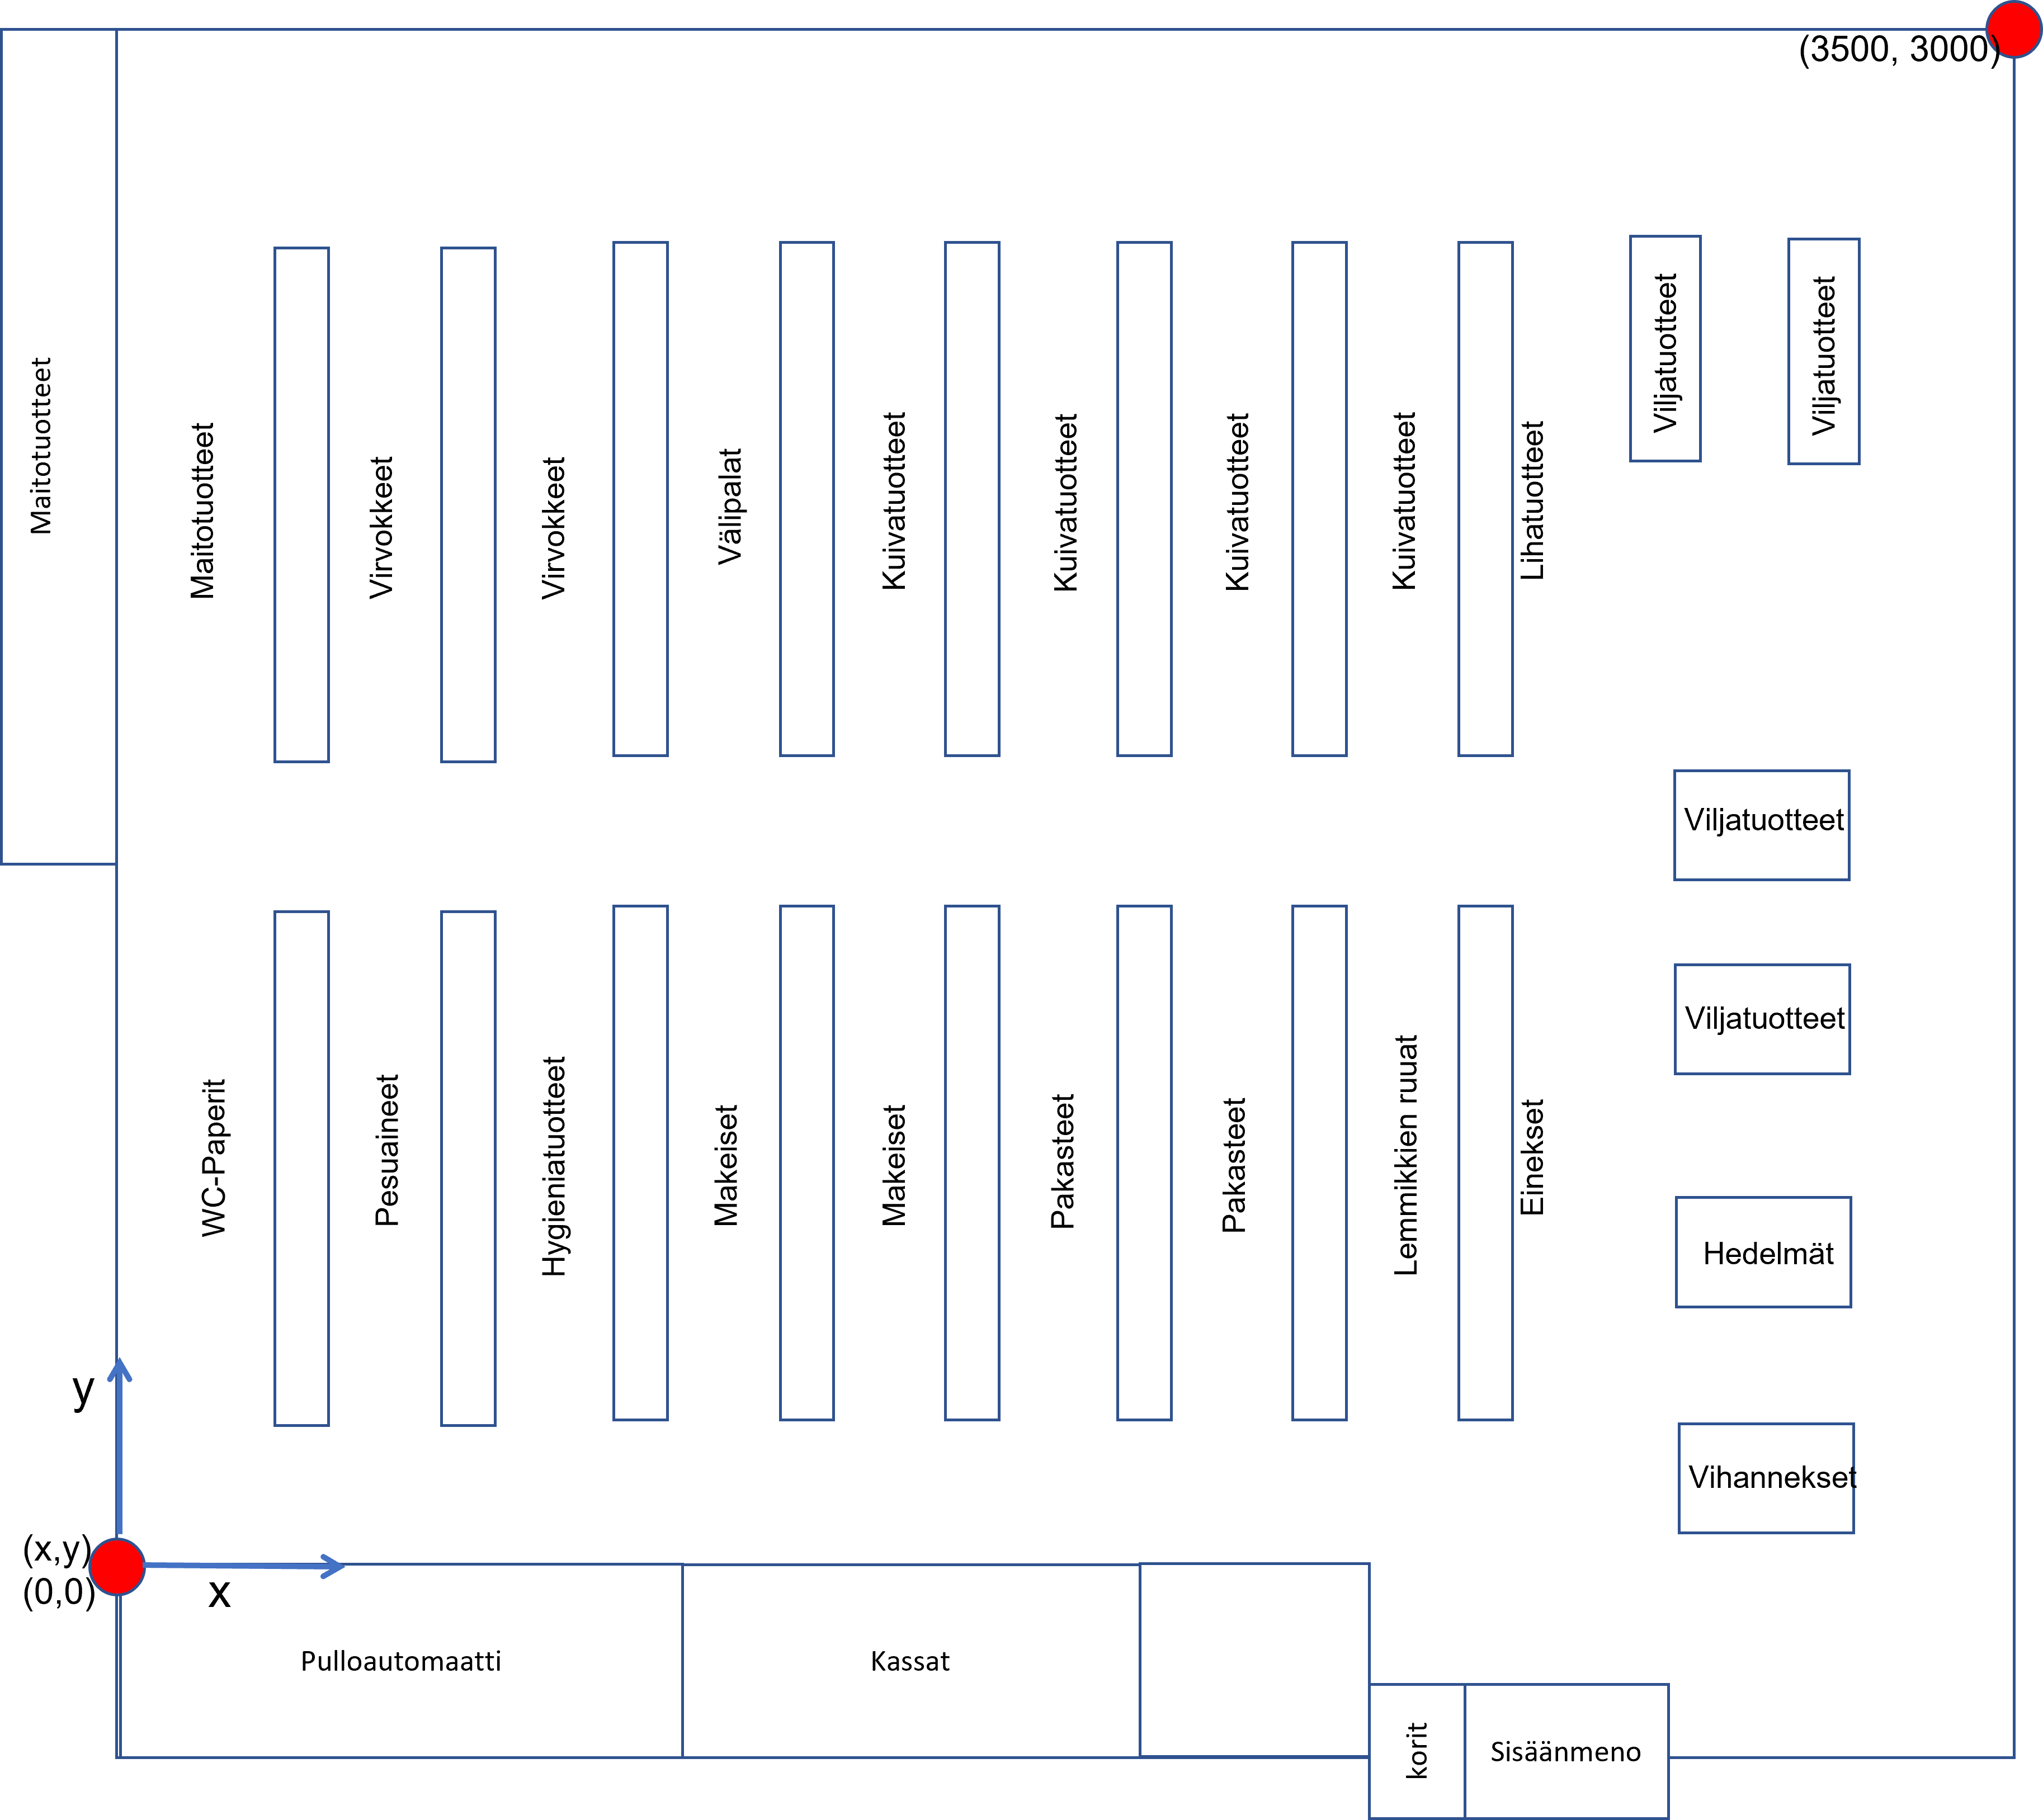

In [6]:
import ipywidgets as widgets
from IPython.display import display, Image
import numpy as np
title = widgets.HTML(
    value="<h2 style='font-size:20px'>random forest classifier</h2>",
)
default_values = ["Vihannekset", "Hedelmät", "Viljatuotteet", "Maitotuotteet"]
dropdowns = [widgets.Dropdown(options=hyllyt, description=f'stop {i+1}:', value=default_values[i]) for i in range(3)]
predict_btn = widgets.Button(description='Predict Next Section')
output = widgets.Output()
display(Image(filename='../layout.png', width=700, height=700))
def nappi(b):
    with output:
        output.clear_output() 
        valitut = [d.value for d in dropdowns if d.value is not None]
        input = np.zeros((1, max_length, num_hyllyt), dtype=int)
        for i, section in enumerate(valitut):
            section_id = section__id[section]
            input[0, i, section_id] = 1
        input_flat = input.reshape(1, -1)

        predicted_id = rf_classifier.predict(input_flat)[0]  # random forest classifier
        predicted = label_encoder.inverse_transform([predicted_id])[0]
        print(f'seuraava ennustettu osasto: {predicted}')
        
predict_btn.on_click(nappi)
widgets.VBox([title, *dropdowns, predict_btn, output])